In [29]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import issparse, coo_matrix, csr_matrix, csc_matrix
from scipy.sparse.linalg import eigsh
from openfermionpyscf import run_pyscf
from openfermion import MolecularData, get_fermion_operator
from openfermion.linalg import get_sparse_operator


In [30]:
def indices_with_N_and_Sz0(n_orbital, n_elec):
    """전자수=N 이면서 S_z=0 (interleaved: 짝수=alpha, 홀수=beta)"""
    idx = []
    for s in range(1 << n_orbital):
        if s.bit_count() != n_elec:
            continue
        n_alpha = sum((s >> i) & 1 for i in range(0, n_orbital, 2))  # 0,2,4,...
        n_beta  = sum((s >> i) & 1 for i in range(1, n_orbital, 2))  # 1,3,5,...
        if n_alpha == n_beta:
            idx.append(s)
    return np.array(idx, dtype=int)

def sparse_to_graph(A, *,
                    directed=False,
                    weight="value",   # "value" | "abs" | "binary"
                    symmetrize=True,  # 무향 그래프용: 패턴을 A + A.T로 합칠지
                    tol=0.0,          # |a_ij|<=tol 은 0 취급
                    keep_diagonal=False):
    """
    희소행렬 A -> NetworkX Graph/DiGraph 변환

    Parameters
    ----------
    A : scipy.sparse matrix (정방 추천)
    directed : bool
        True면 DiGraph, False면 Graph
    weight : {"value","abs","binary"}
        엣지 weight 설정 방법
        - "value": a_ij (실수/복소 가능; 복소는 실수부 사용 권장)
        - "abs"  : |a_ij|
        - "binary": 1 (연결만 표현)
    symmetrize : bool
        무향 그래프에서 A의 패턴을 A + A^T로 결합 (권장)
        directed=True 인 경우엔 무시됨
    tol : float
        임계값 이하 절댓값은 0으로 무시
    keep_diagonal : bool
        True면 i==j 항도 self-loop로 추가

    Returns
    -------
    G : nx.Graph or nx.DiGraph
    """
    if not issparse(A):
        raise ValueError("A must be a scipy.sparse matrix")
    # COO로 변환
    A = A.tocoo(copy=True)

    # tol 필터링
    if tol > 0:
        mask = np.abs(A.data) > tol
        A = coo_matrix((A.data[mask], (A.row[mask], A.col[mask])), shape=A.shape)

    # 대각 요소 처리
    if not keep_diagonal:
        mask = A.row != A.col
        A = coo_matrix((A.data[mask], (A.row[mask], A.col[mask])), shape=A.shape)

    # 무향이면 패턴 대칭화(권장): A <- A + A.T (중복은 합쳐짐)
    if not directed and symmetrize:
        AT = coo_matrix((A.data, (A.col, A.row)), shape=A.shape)
        A = (A + AT).tocoo()

    # 그래프 타입 선택
    G = nx.DiGraph() if directed else nx.Graph()
    G.add_nodes_from(range(A.shape[0]))  # 노드: 0..n-1

    # weight 설정
    if weight == "binary":
        # 동일 (i,j) 중복 합치기 위해 집계
        from collections import defaultdict
        edges = defaultdict(float)
        for i, j, v in zip(A.row, A.col, A.data):
            if not directed and i == j and not keep_diagonal:
                continue
            key = (i, j) if directed else (min(i, j), max(i, j))
            edges[key] = 1.0  # 존재만 표시
        for (i, j), w in edges.items():
            G.add_edge(i, j, weight=w)

    else:
        # "value" 또는 "abs"
        if weight == "abs":
            vals = np.abs(A.data)
        elif weight == "value":
            # 복소인 경우 실수부만 쓰고 싶다면 .real 사용
            # 필요에 따라 변경 가능: vals = np.real(A.data)
            vals = A.data
        else:
            raise ValueError("weight must be 'value', 'abs', or 'binary'")

        # 동일 엣지 중복 합치기(무향일 때 i<j 묶기)
        from collections import defaultdict
        edges = defaultdict(float)
        for i, j, v in zip(A.row, A.col, vals):
            if not directed and i == j and not keep_diagonal:
                continue
            key = (i, j) if directed else (min(i, j), max(i, j))
            edges[key] += float(v)  # 누적(합). 필요시 max/mean 등으로 변경 가능.

        for (i, j), w in edges.items():
            G.add_edge(i, j, weight=w)

    return G

In [31]:
def sparse_to_graph(A, *,
                    directed=False,
                    weight="value",   # "value" | "abs" | "binary"
                    symmetrize=True,  # 무향 그래프용: 패턴을 A + A.T로 합칠지
                    tol=0.0,          # |a_ij|<=tol 은 0 취급
                    keep_diagonal=False):
    """
    희소행렬 A -> NetworkX Graph/DiGraph 변환

    Parameters
    ----------
    A : scipy.sparse matrix (정방 추천)
    directed : bool
        True면 DiGraph, False면 Graph
    weight : {"value","abs","binary"}
        엣지 weight 설정 방법
        - "value": a_ij (실수/복소 가능; 복소는 실수부 사용 권장)
        - "abs"  : |a_ij|
        - "binary": 1 (연결만 표현)
    symmetrize : bool
        무향 그래프에서 A의 패턴을 A + A^T로 결합 (권장)
        directed=True 인 경우엔 무시됨
    tol : float
        임계값 이하 절댓값은 0으로 무시
    keep_diagonal : bool
        True면 i==j 항도 self-loop로 추가

    Returns
    -------
    G : nx.Graph or nx.DiGraph
    """
    if not issparse(A):
        raise ValueError("A must be a scipy.sparse matrix")
    # COO로 변환
    A = A.tocoo(copy=True)

    # tol 필터링
    if tol > 0:
        mask = np.abs(A.data) > tol
        A = coo_matrix((A.data[mask], (A.row[mask], A.col[mask])), shape=A.shape)

    # 대각 요소 처리
    if not keep_diagonal:
        mask = A.row != A.col
        A = coo_matrix((A.data[mask], (A.row[mask], A.col[mask])), shape=A.shape)

    # 무향이면 패턴 대칭화(권장): A <- A + A.T (중복은 합쳐짐)
    if not directed and symmetrize:
        AT = coo_matrix((A.data, (A.col, A.row)), shape=A.shape)
        A = (A + AT).tocoo()

    # 그래프 타입 선택
    G = nx.DiGraph() if directed else nx.Graph()
    G.add_nodes_from(range(A.shape[0]))  # 노드: 0..n-1

    # weight 설정
    if weight == "binary":
        # 동일 (i,j) 중복 합치기 위해 집계
        from collections import defaultdict
        edges = defaultdict(float)
        for i, j, v in zip(A.row, A.col, A.data):
            if not directed and i == j and not keep_diagonal:
                continue
            key = (i, j) if directed else (min(i, j), max(i, j))
            edges[key] = 1.0  # 존재만 표시
        for (i, j), w in edges.items():
            G.add_edge(i, j, weight=w)

    else:
        # "value" 또는 "abs"
        if weight == "abs":
            vals = np.abs(A.data)
        elif weight == "value":
            # 복소인 경우 실수부만 쓰고 싶다면 .real 사용
            # 필요에 따라 변경 가능: vals = np.real(A.data)
            vals = A.data
        else:
            raise ValueError("weight must be 'value', 'abs', or 'binary'")

        # 동일 엣지 중복 합치기(무향일 때 i<j 묶기)
        from collections import defaultdict
        edges = defaultdict(float)
        for i, j, v in zip(A.row, A.col, vals):
            if not directed and i == j and not keep_diagonal:
                continue
            key = (i, j) if directed else (min(i, j), max(i, j))
            edges[key] += float(v)  # 누적(합). 필요시 max/mean 등으로 변경 가능.

        for (i, j), w in edges.items():
            G.add_edge(i, j, weight=w)

    return G

In [32]:
def GBBD(mol, n_e, istwo = False):
    mol = run_pyscf(mol, run_scf=1, run_fci=0)
    # 3. 2차 정량화 Hamiltonian 얻기
    ham_int = mol.get_molecular_hamiltonian()
    ham_fci = get_fermion_operator(ham_int)     
    H = get_sparse_operator(ham_fci, n_qubits=mol.n_qubits)
    print(H.real)
    if istwo == True : 
        H_real = H.real
        eigval, eigvec = eigsh(H_real, which='SA')
        value = eigval[1]
    else : 
        # 2) N=2, S_z=0 서브스페이스 (H2/STO-3G면 4x4)
        idx_N2_Sz0 = indices_with_N_and_Sz0(mol.n_qubits, n_elec=n_e)
        #print(idx_N2_Sz0)
        H_cons = H[idx_N2_Sz0, :][:, idx_N2_Sz0].tocsr()
        H_real = H_cons.real
        #print(H_cons)
        G = sparse_to_graph(H_real, directed=False, weight="abs", symmetrize=True, tol=0.0)
        # 연결 성분
        ccs = list(nx.connected_components(G))
        sub_mat_idx = list(ccs[1])
        H_sub = H_real[sub_mat_idx, :][:, sub_mat_idx]
        print(H_sub)
        eigval, eigvec = eigsh(H_sub, k=1, which='SA')
    return eigval[0]
   

### 행렬만들기

In [33]:
dist = 0.7
#H2
H2_energy_arr = []
for dist in np.arange(0.4,2.5, 0.1):
    geometry = [('H', (0., 0., 0.)),
                ('H', (dist, 0., 0.))]
    basis = 'sto-3g'
    mol = MolecularData(geometry, basis, multiplicity=1, charge=0)
    energy = GBBD(mol,2, istwo = True)
    H2_energy_arr.append(energy)

#H4
H4_energy_arr = []
for dist in np.arange(0.4,2.5, 0.1):
    geometry = [('H', (0., 0., 0.)),
                ('H', (dist, 0., 0. )),
                ('H', (2*dist, 0., 0. )),
                ('H', (3*dist, 0., 0.))]  # Angstrom
    basis = 'sto-3g'
    mol = MolecularData(geometry, basis, multiplicity=1, charge=0)
    energy = 0.5*GBBD(mol,4)
    H4_energy_arr.append(energy)

#H8
H8_energy_arr = []
for dist in np.arange(0.4,2.5, 0.1):
    geometry = [('H', (0., 0., 0.)),
                ('H', (dist, 0., 0. )),
                ('H', (2*dist, 0., 0. )),
                ('H', (3*dist, 0., 0.)),
                ('H', (4*dist, 0., 0.)),
                ('H', (5*dist, 0., 0. )),
                ('H', (6*dist, 0., 0. )),
                ('H', (7*dist, 0., 0.))]

    basis = 'sto-3g'
    mol = MolecularData(geometry, basis, multiplicity=1, charge=0)
    energy = 0.25*GBBD(mol,8)
    H8_energy_arr.append(energy)
    
#H12
# H12_energy_arr = []
# for dist_bond in np.arange(0.4,2.5, 0.1):
#     geometry = [('H', (0., 0., 0.)),
#                 ('H', (dist, 0., 0. )),
#                 ('H', (2*dist, 0., 0. )),
#                 ('H', (3*dist, 0., 0.)),
#                 ('H', (4*dist, 0., 0.)),
#                 ('H', (5*dist, 0., 0. )),
#                 ('H', (6*dist, 0., 0. )),
#                 ('H', (7*dist, 0., 0.)),
#                 ('H', (8*dist, 0., 0.)),
#                 ('H', (9*dist, 0., 0. )),
#                 ('H', (10*dist, 0., 0. )),
#                 ('H', (11*dist, 0., 0.))]
#     basis = 'sto-3g'
#     mol = MolecularData(geometry, basis, multiplicity=1, charge=0)
#     energy = (1/6)*GBBD(mol,12)
#     H12_energy_arr.append(energy)


<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 20 stored elements and shape (16, 16)>
  Coords	Values
  (0, 0)	1.3229430273
  (1, 1)	1.204207977203953
  (2, 2)	1.204207977203953
  (3, 3)	1.8509163240944293
  (12, 3)	0.1645154240225661
  (4, 4)	-0.15914885987894656
  (5, 5)	0.28293410227108623
  (6, 6)	0.44744952629365237
  (9, 6)	-0.1645154240225661
  (7, 7)	1.6549758854302088
  (8, 8)	-0.15914885987894656
  (6, 9)	-0.1645154240225661
  (9, 9)	0.44744952629365237
  (10, 10)	0.28293410227108623
  (11, 11)	1.6549758854302088
  (3, 12)	0.1645154240225661
  (12, 12)	-0.9043613941635393
  (13, 13)	0.26305500425513983
  (14, 14)	0.26305500425513983
  (15, 15)	2.195914799660342
<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 20 stored elements and shape (16, 16)>
  Coords	Values
  (0, 0)	1.05835442184
  (1, 1)	0.8014186394429679
  (2, 2)	0.8014186394429679
  (3, 3)	1.289322227415821
  (12, 3)	0.16887022768973542
  (4, 4)	-0.3521739458781672
  (5, 5)	-0.07074

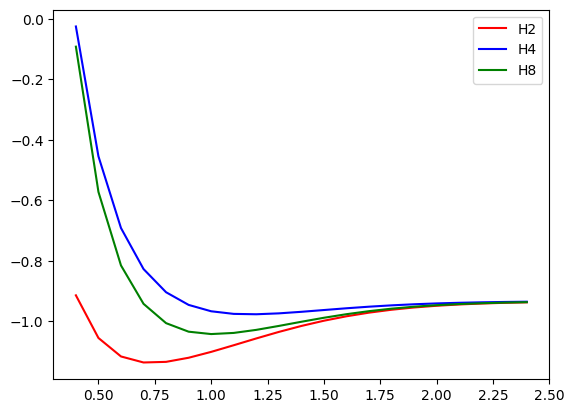

In [34]:
x = np.arange(0.4,2.5, 0.1)
plt.plot(x,H2_energy_arr, color='red',label='H2')
plt.plot(x,H4_energy_arr, color='blue',label='H4')
plt.plot(x,H8_energy_arr, color='green',label='H8')
#plt.plot(x,H12_energy_arr, color='purple',label='H12')
plt.legend()
plt.show()

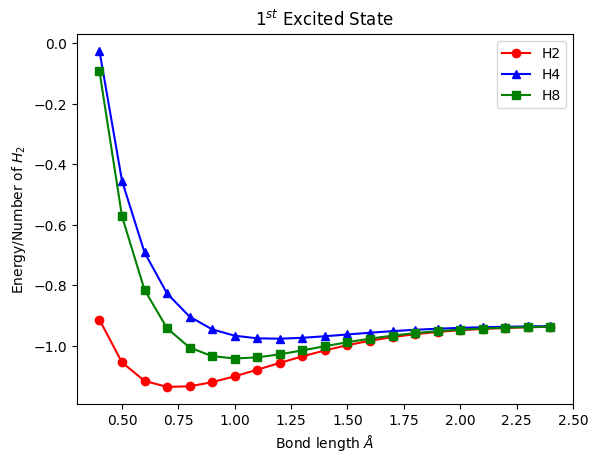

In [42]:
x = np.arange(0.4,2.5, 0.1)
plt.plot(x,H2_energy_arr,'-o', color='red',label='H2')
plt.plot(x,H4_energy_arr, '-^',color='blue',label='H4')
plt.plot(x,H8_energy_arr,'-s', color='green',label='H8')
#plt.plot(x,H12_energy_arr, color='purple',label='H12')
plt.title('$1^{st}$ Excited State')
plt.xlabel('Bond length $\\AA$')
plt.ylabel('Energy/Number of $H_2$')
plt.legend()
plt.show()